# Random Forest

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from pathlib import Path

import sys
sys.path.append('../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

### Initialising

In [3]:
# initialising WandB
import wandb, os

os.environ["WANDB_API_KEY"] = "e84d2e19bd2cc42ec6e5d232cd0b6f0fe41f2189"
os.environ["WANDB_NOTEBOOK_NAME"] = "randomforest_models.ipynb"

In [4]:
# Load the data
data = pd.read_csv(data_path/'for_model_pca.csv', parse_dates=['time'])

data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,flag
8791,2008-12-09 04:08:00,-13.810294,5.242953,-0.966785,-1.310597,1.137769,0.829760,-0.549607,1.782570,1.207704,...,-1.137353,0.312279,-0.119590,0.696805,1.493021,-0.068322,1.427406,0.268118,0.047225,1.0
18697,2018-07-19 03:10:00,-4.819471,-3.615290,-0.776134,-4.136356,1.038540,0.722561,1.102200,-0.590905,0.005671,...,-0.594157,-0.369950,-0.614024,0.217000,-0.830833,-0.944422,0.108572,-0.066009,-0.343760,1.0
21885,2021-11-06 14:30:00,0.254070,6.697540,-6.731990,-2.363456,-1.847013,0.040401,-1.685037,-1.154538,-0.850119,...,0.680254,0.617556,0.614310,-0.096086,0.336945,-1.088581,-0.421256,-0.522307,0.659868,1.0
3032,2003-05-13 16:05:00,-5.947681,3.832348,2.063314,3.303908,-1.837285,0.890874,-0.850165,-0.946917,-1.319995,...,-0.169969,-0.746540,-0.097757,-0.645420,-0.910434,0.465885,0.550100,0.909977,-0.210945,1.0
13788,2013-11-01 04:40:00,6.999081,2.697848,-1.316249,-0.721944,-2.830900,1.101743,0.738973,3.047015,1.067360,...,-0.549512,-0.825661,0.620914,-0.596856,0.383658,-1.262118,-1.095188,0.994862,-0.659610,1.0


In [13]:
# Convert "time" column to datetime format
#data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y %H:%M')

# Split the data into training and testing sets based on the date
train_data = data[(data['time'].dt.year >= 2016) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")

# saving the date ranges for WandB tracking
# training_date_range = "2016"
# validation_date_range = "2020-01-01 to 2020-12-31"
# testing_date_range = "2020-01-01 to 2022-12-31"

# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2016-01-01 02:09:00 -> 2018-12-31 16:10:00. Length: 3118
Val range: 2019-01-01 13:50:00 -> 2019-12-29 18:29:00. Length: 642
Test range: 2020-01-03 00:50:00 -> 2022-12-31 08:37:00. Length: 2978


## Models

### Basic Model with Default Parameters

Shows very basic set-up of model, and how the train/validation/train process works.

In [14]:
# wandb.init(project="Random Forest 2.0")

# setting up initial model on training data
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

# making predictions on training and validation data
y_pred_val = rf_model.predict(X_val)
y_pred_train = rf_model.predict(X_train)

# calculating metrics
precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_score_val = f1_score(y_val, y_pred_val)
f1_score_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_score_train:.3f}")
print(f"F1 Score on Validation Set = {f1_score_val:.3f}")

# wandb.log({"model_name":"Basic model, default parameters", "training_precision":precision_train, "testing_precision":precision_test, 
            # "training_recall":recall_train, "testing_recall":recall_test, "training_f1":f1_score_train, "testing_f1":f1_score_test,
            # "training date range": training_date_range, "testing date range": testing_date_range})

# wandb.finish()

Precision on Training Set = 1.000
Precision on Validation Set = 0.840
Recall on Training Set = 1.000
Recall on Validation Set = 0.944
F1 Score on Training Set = 1.000
F1 Score on Validation Set = 0.889


In [15]:
# now making predictions on the test data
y_pred_test = rf_model.predict(X_test)

# calculating metrics
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_score_test:.3f}")

Precision on Test Set = 0.891
Recall on Test Set = 0.949
F1 Score on Test Set = 0.919


### Class Probabilities Model

Focusing on a model that makes predictions based on class probabilities in order to optimise precision.

#### Initial Model

In [18]:
# wandb.init(project="Random Forest 2.0")

rf_model = RandomForestClassifier(random_state=42, n_estimators=200)

rf_model.fit(X_train, y_train)

# finding class probabilities for each sample - using validation set
class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

# make predictions based on threshold
y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


# Calculate scores
precision_train = precision_score(y_train, y_pred_train)
precision_val = precision_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Testing Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Testing Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Testing Set = {f1_val:.3f}")


# wandb.log({"model_name":"Class probabilities model", "training_precision":precision_train_threshold, "testing_precision":precision_test_threshold, 
            # "training_recall":recall_train_threshold, "testing_recall":recall_test_threshold, "training_f1":f1_train_threshold, "testing_f1":f1_test_threshold,
            # "training date range": training_date_range, "testing date range": testing_date_range})

# wandb.finish()

Precision on Training Set = 1.000
Precision on Testing Set = 0.963
Recall on Training Set = 0.990
Recall on Testing Set = 0.592
F1 Score on Training Set = 0.995
F1 Score on Testing Set = 0.734


#### Optimising Model Using Validation Set

##### Optimising Threshold

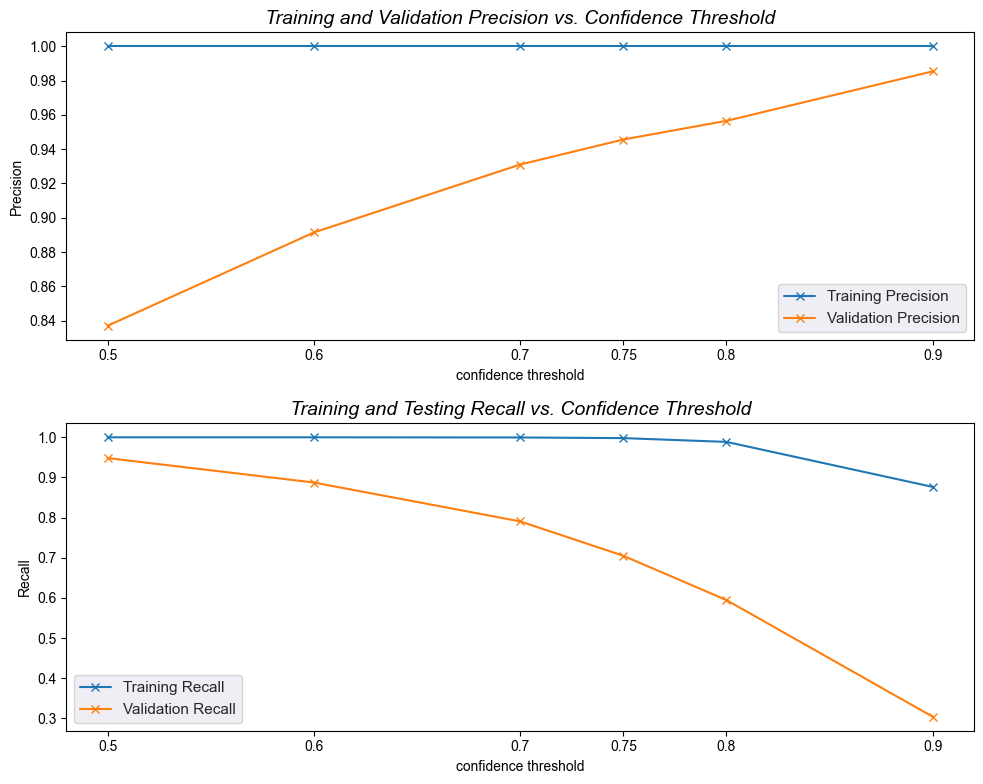

In [19]:
confidence_threshold_vals = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]

train_precisions_values = []
val_precisions_values = []
train_recalls_values = []
val_recalls_values = []

directory = './results'
file_path = os.path.join(directory, 'threshold_results.csv')

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # adding header
    writer.writerow(['Confidence Threshold', 'Training Precision', 'Validation Precision', 'Training Recall', 'Validation Recall'])

    for threshold in confidence_threshold_vals:
        rf_model = RandomForestClassifier(random_state=42)
        rf_model.fit(X_train, y_train)

        class_probabilities_val = rf_model.predict_proba(X_val)
        class_probabilites_train = rf_model.predict_proba(X_train)
        
        # make predictions based on threshold
        y_pred_val = (class_probabilities_val[:, 1] >= threshold).astype(int)
        y_pred_train = (class_probabilites_train[:, 1] >= threshold).astype(int)

        # calculating precision & recall of validation/training sets
        val_precision = precision_score(y_val, y_pred_val)
        train_precision = precision_score(y_train, y_pred_train)
        val_recall = recall_score(y_val, y_pred_val)
        train_recall = recall_score(y_train, y_pred_train)

        train_precisions_values.append(train_precision)
        val_precisions_values.append(val_precision)
        train_recalls_values.append(train_recall)
        val_recalls_values.append(val_recall)

        writer.writerow([threshold, train_precision, val_precision, train_recall, val_recall])

# reading in results
results = pd.read_csv('results/threshold_results.csv')

# plotting
fig, axs = plt.subplots(2,1, figsize=(10, 8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# line plot of precision vs. max_depth (training and validation)
axs[0].plot(results['Confidence Threshold'], results['Training Precision'], label='Training Precision', marker='x')
axs[0].plot(results['Confidence Threshold'], results['Validation Precision'], label='Validation Precision', marker='x')
axs[0].set_xlabel('confidence threshold')
axs[0].set_xticks(results['Confidence Threshold'])
axs[0].set_xticklabels(results['Confidence Threshold'])
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].set_title('Training and Validation Precision vs. Confidence Threshold', fontstyle='italic', fontsize=14)

# line plot of recall vs. max_depth (training and validation)
axs[1].plot(results['Confidence Threshold'], results['Training Recall'], label='Training Recall', marker='x')
axs[1].plot(results['Confidence Threshold'], results['Validation Recall'], label='Validation Recall', marker='x')
axs[1].set_xlabel('confidence threshold')
axs[1].set_xticks(results['Confidence Threshold'])
axs[1].set_xticklabels(results['Confidence Threshold'])
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].set_title('Training and Validation Recall vs. Confidence Threshold', fontstyle='italic', fontsize=14)

fig.tight_layout()

##### Exploring max_depth

This particular hyperparameter has shown to help significantly with overfitting issues so this is explored first.

In [45]:
# List of max_depth values to try
max_depth_values = [3, 5, 6, 7, 8, 9, 10, 12, 15, 20]

train_precisions_values = []
val_precisions_values = []
difference_values = []

directory = './results'
file_path = os.path.join(directory, 'max_depth_results.csv')

# creating csv file to store results - allows for easy plotting/analysis
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # adding header
    writer.writerow(['Max Depth', 'Training Precision', 'Validation Precision', 'Difference'])

    for max_depth in max_depth_values:
        rf_model = RandomForestClassifier(random_state=42, max_depth=max_depth)
        rf_model.fit(X_train, y_train)

        # finding class probabilities for each sample
        class_probabilities_val = rf_model.predict_proba(X_val)
        class_probabilites_train = rf_model.predict_proba(X_train)

        confidence_threshold = config.confidence_threshold

        # make predictions based on threshold
        y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
        y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)

        # calculating precision of testing/training sets
        val_precision = precision_score(y_val, y_pred_val)
        train_precision = precision_score(y_train, y_pred_train)
        difference = abs(train_precision-val_precision)

        train_precisions_values.append(train_precision)
        val_precisions_values.append(val_precision)
        difference_values.append(difference)

        writer.writerow([max_depth, train_precision, val_precision, difference])


results = pd.read_csv('results/max_depth_results.csv')

# plotting
fig, axs = plt.subplots(2,1, figsize=(10, 8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# line plot of precision vs. max_depth (training and validation)
axs[0].plot(results['Max Depth'], results['Training Precision'], label='Training Precision', marker='x')
axs[0].plot(results['Max Depth'], results['Validation Precision'], label='Validation Precision', marker='x')
axs[0].set_xlabel('max_depth')
axs[0].set_xticks(results['Max Depth'])
axs[0].set_xticklabels(results['Max Depth'].astype(int))
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].set_title('Training and Validation Precision vs. max_depth', fontstyle='italic', fontsize=14)

# bar chart of difference between training and validation precision
axs[1].bar(results['Max Depth'], results['Difference'])

# Add data labels to the bar chart
for i, v in zip(results['Max Depth'], results['Difference']):
    axs[1].text(i, v, f"{v:.2f}", fontsize=8, ha='center', va='bottom')

axs[1].set_xlabel('max_depth')
axs[1].set_xticks(results['Max Depth'])
axs[1].set_xticklabels(results['Max Depth'].astype(int))

axs[1].set_ylabel('Difference')
axs[1].set_title('Difference between Training and Validation Precision vs. max_depth', fontstyle='italic', fontsize=14)

fig.tight_layout()

##### Grid Search

In [ ]:
model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to search over
'''
INITIAL GRID
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']}
'''
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap' : [True, False]
}

# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, scoring='f1')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# extracting best parameters and score
results = grid_search.best_estimator_

validation_f1 = results.score(X_val, y_val)

print(f'Validation F1 Score: {validation_f1:.3f}')
print(f'Best Parameters: {grid_search.best_params_}')

#### Applying Optimisations to Model

In [20]:
# wandb.init(project="Random Forest 2.0")

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=3,
                                  criterion='entropy',)

rf_model.fit(X_train, y_train)

# making predictions based on confidence threshold
class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


# calculating performance metrics
precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")


# wandb.log({"model_name":"Optimising hyperparameters", "training_precision":precision_train, "testing_precision":precision_test, 
            # "training_recall":recall_train, "testing_recall":recall_test, "training_f1":f1_train, "testing_f1":f1_test,
            # "training date range": training_date_range, "testing date range": testing_date_range})

# wandb.finish()

Precision on Training Set = 0.942
Precision on Validation Set = 0.919
Recall on Training Set = 0.784
Recall on Validation Set = 0.743
F1 Score on Training Set = 0.856
F1 Score on Validation Set = 0.822


##### Evaluating Model on Test Data

In [21]:
class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.939
Recall on Test Set = 0.721
F1 Score on Test Set = 0.816


In [ ]:
# Save the model
dump(rf_model, data_path/'rf_model.joblib')